<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/colab/Buckley_Leverett_Gravity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 水油置換問題の重力の影響（Buckley-Leverettによる解法）

油で満たされている多孔質媒体に水を圧入し水攻するとき，一次元／非圧縮／非混和条件を仮定すると，**Buckley-Leverettの解法** により、ある時間に対する飽和率分布を解析的に求めた

前のノートブックでは重力の影響を無視していたので，ここでは重力の影響を確認したい．

## 重力を考慮したフラクショナルフロー

毛細管圧力による影響は無視し，重力の影響を考慮した場合の水のフラクショナルフロー関数は（いろいろ表し方はあるが）次のようになる．

$$
f_w = \frac{\lambda_w}{\lambda_t} \left( 1 - k_{ro} N_g  \sin \theta \right)
$$

ここで，$\lambda_w$ と $\lambda_t$ はそれぞれ水と両相合算のモビリティ， $N_g$ は重力数，$\theta$ は傾斜角である．
$N_g$ は次のように表される．

$$
N_g = \frac{\left( k / \mu_o \right) \Delta \rho g}{u_t}
$$

ここで，$k$ は絶対浸透率， $\Delta \rho$ は密度差 ($\Delta \rho = \rho_w - \rho_o$), $g$ は重力加速度である．

**ライブラリのインポート**

In [0]:
import sys
import numpy as np
import matplotlib.pyplot as plt

計算には，https://github.com/mayuneko-re/notebook.git にある buckley_leverett.py を使用する．Colaboratory上で `wget` してそのまま使う．

In [2]:
!rm -r buckley_leverett.py
!wget -nv https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/buckley_leverett.py
from buckley_leverett import BL

rm: cannot remove 'buckley_leverett.py': No such file or directory
2019-11-16 12:16:24 URL:https://raw.githubusercontent.com/mayuneko-re/notebook/master/py/buckley_leverett.py [5706/5706] -> "buckley_leverett.py" [1]


## 感度解析

重力の考慮するため，BLを継承、fw計算メソッド `BL.calc_fw(self)`をオーバーライドする．


In [0]:
class BLwGravity(BL):

    def enable_gravity(self, theta, k, drho, ut):
        g = 9.8 # m/s2, Gravitational acceleration
        self.theta = theta # Dip angle
        self.k = 10 # d, Absolute permeability
        self.drho = 0.2 # g/cm3, Difference in density 
        self.ut = 0.1 # ft/day, Total volumetric flow velocity
        self.Ng = (self.k / self.muo) * self.drho * g / self.ut * 0.283
        # 0.283 is a unit conversion factor 
        # 1 md = 1e-12 m2
        # 1 g/cm3 = 1e3 kg/m3
        # 1 cP = 1e-3 kg/m-s
        # 1 ft/day = 3.5278e-6 m/s


    def calc_fw(self):
        fw = (self.krw/self.muw) / (self.krw/self.muw + self.kro/self.muo) # Oritinal
        fw = fw * (1 - self.kro * self.Ng * np.sin(np.deg2rad(self.theta) )) # with Gravity
        return fw


ここでは，Dip angleを-30°，0°，30°で計算してみる．

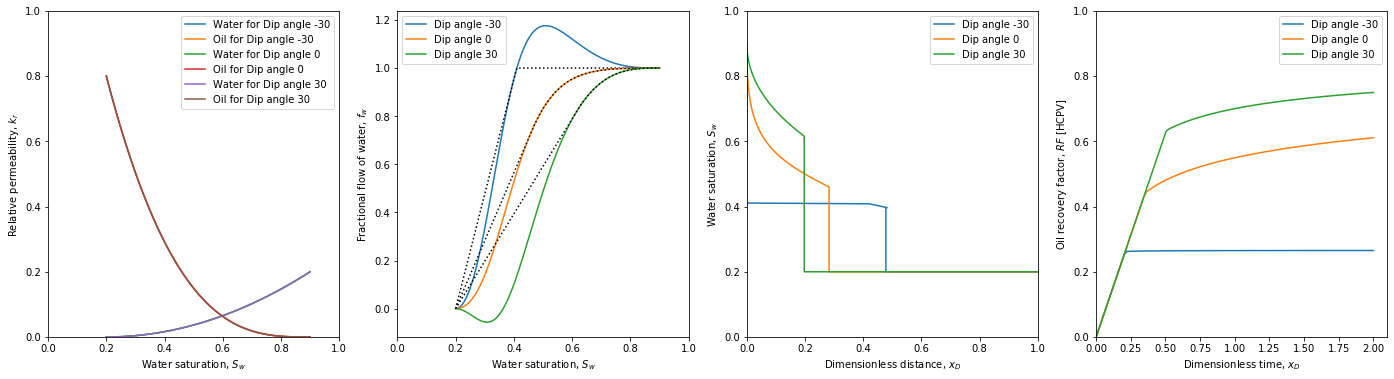

In [4]:
theta_list = [-30, 0 , 30]

d_core = {'Swc':0.2, 'Sor':0.1, 'krw0':0.2, 'kro0':0.8, 'nw':2, 'no':3}
d_fluid = {'muw':0.5, 'muo':10}

fig, ax = plt.subplots(1,4,figsize=(24, 6))

for theta in theta_list:
    bl = BLwGravity(**d_core, **d_fluid, **{'label':'Dip angle '+str(theta)})
    bl.enable_gravity(theta, k=10, drho=0.2, ut=0.1)
    bl.calc()

    tD = np.linspace(start=0, stop=2, num = 100)
    
    # Plot ######
    # Relative permeability
    ax[0].plot(bl.Sw, bl.krw, label='Water for '+bl.label)
    ax[0].plot(bl.Sw, bl.kro, label='Oil for '+bl.label)
    
    # Fractional flow of water
    ax[1].plot(bl.Sw, bl.fw, label=bl.label)
    ax[1].plot(bl.Sw, bl.fw_wSF, 'k:')

    # Saturation profile at specific time
    xD, Sw = bl.get_Sw_profile(tD=0.1)
    ax[2].plot(xD, Sw, label=bl.label)

    # Oil recovery
    ax[3].plot(tD, bl.get_oil_RF(tD), label=bl.label)
    

def adjust_ax(ax, xlabel=None, ylabel=None, xlim=(0,1), ylim=(0,1)):
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


adjust_ax(ax[0], 'Water saturation, $S_w$', 'Relative permeability, $k_r$')
adjust_ax(ax[1], 'Water saturation, $S_w$', 'Fractional flow of water, $f_w$', ylim=None)
adjust_ax(ax[2], 'Dimensionless distance, $x_D$', 'Water saturation, $S_w$')
adjust_ax(ax[3], 'Dimensionless time, $x_D$', 'Oil recovery factor, $RF$ [HCPV]', xlim=(0))

Dip angleの違いにより，水のフラクショナルフロー関数の形状が異なるようになった．

Dip angleが正の場合，水と油の密度差により，フラクショナルフロー関数に負の領域が現れる．ショックフロントの飽和率領域が大きく，飽和率プロファイルはピストンライクな置換を示すようになる．安定で効率的な置換が起こり，高い回収率が期待できる．

一方，Dip angleが負の場合，水と油の密度差により，フラクショナルフロー関数に1を超える領域（対向流）が現れる．ショックフロントの飽和率領域が小さく，速い進展，早期のブレークスルーが予測される．非効率的な置換が起こり，回収率はあまり期待できなさそうである．


*End of notebook...*